# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [2]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
999,5010,49962,London,17-03-2020,Tritax Big Box (BBOX) battered today as invest...,Negative
6968,12274,57226,"Owen Sound, Ontario",19-03-2020,"Honestly, it didnÃÂt feel real that the covi...",Negative
30937,41859,86811,Geek USA - 365/24/7,11-04-2020,"HUGE Kudos to ""ALL"" the Frontline workers, esp...",Extremely Positive
9962,15900,60852,NaN,21-03-2020,2008 Lehman vs COVID 19 3 20 Blue chip stock p...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуем ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [4]:
#смотрим значения, которые используются в этом столбце
df.Sentiment.unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [15]:
# кодирование
df.Sentiment = df.Sentiment.apply(lambda x: 1 if x == 'Positive' or x == 'Extremely Positive' else 0)

In [6]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1
...,...,...,...,...,...,...
33439,44949,89901,OHIO,14-04-2020,I never that weÃÂd be in a situation &amp; w...,1
33440,44950,89902,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,1
33441,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,0
33442,44953,89905,NaN,14-04-2020,You know itÃÂs getting tough when @KameronWi...,1


Сбалансированы ли классы?

In [ ]:
# смотрим количество наблюдений по класса
df.Sentiment.value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [ ]:
#разница в процентах между классами
(1 - df.Sentiment.value_counts().loc[0] / df.Sentiment.value_counts().loc[1]) * 100

14.673611880749194

**Ответ:** В целом, несмотря на разное количество объектов в каждом классе, дисбаланс классов не сильный (всего 15%), поэтому можно считать, что классы сбалансированы

Выведем на экран информацию о пропусках в данных. Если пропуски присутствуют, заполним их строкой 'Unknown'.

In [7]:
# смотрим наличие пропусков
df.isna().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [16]:
# заполняем пропуски
df.Location = df.Location.fillna('Unknown')

In [9]:
#проверка
df.isna().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделим данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [17]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=0, test_size=0.3)

## Задание 2 Токенизация (3 балла)

Постройим словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [21]:
from collections import Counter
full_text = ' '.join(train.OriginalTweet.values) #чтобы построить общий словарь (как, например, в методе bag-of-words) нужно объединить все твиты в единый текст
full_text = [word.lower() for word in full_text.split()] #дробим по пробелам и приводим в нижний регистр
cnt = Counter(full_text) #подсчет слов для создания словаря частотности
freq_dict = dict(cnt)

In [ ]:
#Другой способ (с циклами)
#arr = train.OriginalTweet.apply(lambda x: x.lower().split()).values
#freq_dict = {}
#for lst in arr:
#  for word in lst:
#    freq_dict[word] = freq_dict.get(word, 0) + 1

Какой размер словаря получился?

In [12]:
len(freq_dict)

79755

Выведем 10 самых популярных токенов с количеством встреч каждого из них

In [13]:
top_words = sorted(freq_dict, key = freq_dict.get, reverse = True)[:10]
for word in top_words:
  print(word,'-', freq_dict[word])

the - 26815
to - 23373
and - 14684
of - 13012
a - 11737
in - 11198
for - 8566
#coronavirus - 8223
is - 7383
are - 7050


**Ответ:** Эти токены наиболее часто встречаются, потому что это стоп-слова, то есть слова, которые являются неотъемлемой частью любого предложения, но какого-то дополнительного смысла они не дают. То есть это предлоги, артикли и другие служебные части речи. Единственным исключением является тег #coronavirus, так как все эти твиты собраны на эту тему, они включают этот тег как характеристику содержания текста.

Удалим стоп-слова из словаря и выведем новый топ-10 токенов (и количество встреч) по популярности

In [22]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
stop_words = stopwords.words('english')

full_text = ' '.join(train.OriginalTweet.values) #объединяем в полный текст
full_text = [word.lower() for word in full_text.split() if not word.lower() in stop_words]
cnt = Counter(full_text) #подсчет слов для создания словаря частотности
freq_dict = dict(cnt)

In [15]:
top_words = sorted(freq_dict, key = freq_dict.get, reverse = True)[:10]
for word in top_words:
  print(word,'-', freq_dict[word])

#coronavirus - 8223
prices - 3891
food - 3820
grocery - 3469
supermarket - 3288
people - 3175
covid-19 - 3173
store - 3155
#covid19 - 2471
&amp; - 2314


In [ ]:
#Другой способ (с циклами)
#import nltk
#from nltk.corpus import stopwords

#nltk.download("stopwords", quiet=True)
#freq_dict_updated = {}
#stop_words = stopwords.words('english')
#for word in freq_dict:
#  if word not in stop_words:
#    freq_dict_updated[word] = freq_dict[word]
#top_words = sorted(freq_dict_updated, key = freq_dict_updated.get, reverse = True)[:10]
#for word in top_words:
#  print(word,'-', freq_dict_updated[word])

**Ответ:**  Так как удалили стоп-слова, то топ популярных слов поменялся. Также остались теги с коронавирусом, так как эти твиты о нем, также появились другие слова, отражаюшие наиболее волнующие в то время темы - проблема с походом в магазины и покупкой еды в условиях изоляции

Также выведем 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [16]:
least_words = sorted(freq_dict, key = freq_dict.get)[:20]
for word in least_words:
  print(word,'-', freq_dict[word])

https://t.co/1m881cwfuv - 1
happy.. - 1
https://t.co/z0intks34x - 1
mnuchinãâs - 1
brink. - 1
https://t.co/jmobv8z0u0 - 1
university's - 1
teaching.) - 1
@catholicpres - 1
@catholicuniv - 1
https://t.co/evqby035wf - 1
https://t.co/riqrhxxeim - 1
@@ballardspahrll - 1
#aca - 1
easier...take - 1
ãânecessaryãâ - 1
https://t.co/0fmsmlgepm - 1
husted: - 1
irishman - 1
#happystpatricksday! - 1


In [ ]:
#Продолжение варианта с циклами
#least_words = sorted(freq_dict_updated, key = freq_dict_updated.get)[:20]
#for word in least_words:
#  print(word,'-', freq_dict_updated[word])

**Ответ:** Наименее популярные токены включают в себя по большей части ссылки или обращения к другим пользователям по их никнейму. Так как эти обращения не несут в себе никакой дополнительной информации, но увеличивают объем словаря, лучше их удалить из анализа



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Применим его и посмотрим на топ-10 популярных слов

In [23]:
from nltk.tokenize import TweetTokenizer
full_text = ' '.join(train.OriginalTweet.values) #объединяем в полный текст, чтобы составить полный словарь

tw = TweetTokenizer()
list_of_words = tw.tokenize(full_text)
cnt = Counter(list_of_words) #подсчет слов для создания словаря частотности
freq_dict = dict(cnt)

In [18]:
top_words = sorted(freq_dict, key = freq_dict.get, reverse = True)[:10]
for word in top_words:
  print(word,'-', freq_dict[word])

the - 24337
. - 24108
to - 22933
, - 17571
and - 14354
of - 12904
a - 11045
in - 10573
? - 9524
for - 8228


**Ответ:** Так как стоп-слова еще не были убраны, они являются наиболее часто используемыми токенами. Отличие заключается в том, что TweetTokenizer еще отдельно выделил пунктуацию от слов, в случае использования split мы разделяли по пробелу, поэтому пунктуация была склеена со словами

Удалим из словаря стоп-слова и пунктуацию, посмотрим на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [24]:
from string import punctuation
cnt = Counter([word.lower() for word in list_of_words if word.lower() not in punctuation and word.lower() not in stop_words])
freq_dict = dict(cnt)

In [20]:
top_words = sorted(freq_dict, key = freq_dict.get, reverse = True)[:10]
for word in top_words:
  print(word,'-', freq_dict[word])

#coronavirus - 8808
â - 7415
 - 7311
19 - 7167
covid - 6253
prices - 4601
 - 4372
food - 4367
store - 3877
supermarket - 3805


**Ответ:** Появляются слова, но еще много присутствует не несущих смысловой нагрузки знаков

Удалим из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведем топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [21]:
#cnt = Counter([word.lower() for word in list_of_words if word.lower() not in punctuation and word.lower() not in stop_words and len(word) != 1 and not ord(word) >= 128])
list_of_words_new = []
for word in list_of_words:
  if len(word) == 1 and ord(word) >= 128:
    continue
  elif word.lower() not in punctuation and word.lower() not in stop_words:
    list_of_words_new.append(word.lower())

cnt = Counter(list_of_words_new)
freq_dict = dict(cnt)

In [22]:
top_words = sorted(freq_dict, key = freq_dict.get, reverse = True)[:10]
for word in top_words:
  print(word,'-', freq_dict[word])

#coronavirus - 8808
19 - 7167
covid - 6253
prices - 4601
food - 4367
store - 3877
supermarket - 3805
grocery - 3523
people - 3463
#covid19 - 2589


**Ответ:** Теперь убрана вся пунктуация и не имеющие смысла знаки, оставлены только слова со смыслом. Также так как в случае с split пунктуация была приклеена к слову, то слова, например, "prices," и "prices", считались разными, в случае с TweetTokenizator эта проблема исправлена, поэтому частота слова увеличилась

Выведем топ-10 популярных хештегов с количеством встреч

In [23]:
hashtags = dict(filter(lambda x: x[0].startswith('#'), freq_dict.items()))
top_hashtags = sorted(hashtags, key = hashtags.get, reverse = True)[:10]
for word in top_hashtags:
  print(word,'-', hashtags[word])

#coronavirus - 8808
#covid19 - 2589
#covid_19 - 1734
#covid2019 - 946
#toiletpaper - 744
#covid - 641
#socialdistancing - 465
#coronacrisis - 448
#pandemic - 257
#coronaviruspandemic - 249


**Ответ:** Так как твиты специально собраны на тему коронавируса, то преобладают хэштеги, связанные с коронавирусом и пандемией. Помимо этого, включен хэштэг с туалетной бумагой, так как это было насущной проблемой во время пандемии

То же самое проделаем для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [24]:
urls = dict(filter(lambda x: x[0].startswith('https://t.co'), freq_dict.items()))
top_urls = sorted(urls, key = urls.get, reverse = True)[:10]
for word in top_urls:
  print(word,'-', urls[word])

https://t.co/oxa7swtond - 5
https://t.co/gp3eusapl8 - 4
https://t.co/deftrui1pfãâ - 3
https://t.co/wrlhyzizaa - 3
https://t.co/kuwipf1kqw - 3
https://t.co/zjnrx6dkkn - 3
https://t.co/3gbbdpdjat - 3
https://t.co/e2znxajpre - 3
https://t.co/catkegayoy - 3
https://t.co/g63rp042ho - 3


**Ответ:** Ссылки используются менее часто, чем хештеги. Они несует мало полезной информации, поэтому их лучше убрать из анализа

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [25]:
def custom_tokenizer(text):

  text = text.lower()

  tw = TweetTokenizer()
  text = tw.tokenize(text)

  tokens = []
  for word in text:
    if (len(word) == 1 and ord(word) >= 128) or word.startswith('https://t.co'):
      continue
    elif word not in punctuation and word not in stop_words:
      tokens.append(word.lower())

  return tokens

In [26]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучим CountVectorizer с использованием custom_tokenizer в качестве токенайзера

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer = custom_tokenizer)
train_transformed = cv.fit_transform(train.OriginalTweet)
test_transformed = cv.transform(test.OriginalTweet)
print(len(cv.vocabulary_))

45308


**Ответ:** Размер словаря меньше, так как в изначальном словаре был использован split и текст не был очищен от бесмысленных элементов

Посмотрим на какой-нибудь конкретный твитт:

In [29]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0)

In [31]:
#text = train.iloc[ind]['OriginalTweet'].lower()
text = train.iloc[ind]['OriginalTweet']

In [59]:
frequency_of_word = cv.transform([text]).toarray()[0] #результат применения CountVectorizer
important = cv.get_feature_names_out()[np.where(frequency_of_word == np.max(frequency_of_word))] #токены, которые имеют максимальную компоненту в векторе
print('Самые важные токены:')
print(important)

Самые важные токены:
['#coronavirusoutbreak' '#covid2019' '@skynews' 'brainless' 'ffs' 'food'
 'france' 'lets' 'nice' 'one' 'panic' 'ppl' 'queueing' 'show']


In [45]:
print('Токены, компонента которых в векторе минимальна, без учета 0:')
print(cv.get_feature_names_out()[np.where((frequency_of_word == np.min(frequency_of_word)) * (frequency_of_word != 0))] ) #их нет, потому что в тексте все слова встречаются максимум по одному разу (токены с макс компонентой)

Токены, компонента которых в векторе минимальна, без учета 0:
[]


In [48]:
np.unique(frequency_of_word) #то есть слова либо один раз встречаются, либо не встречаются вообще

array([0, 1])

In [49]:
np.min(frequency_of_word)

0

In [60]:
print('Наименее важные элементы в твите:')
not_imp = [word for word in text.lower().split() if word not in important and '!' not in word] #наименее важные элементы в данном твите
not_imp

Наименее важные элементы в твите:


['not', 'but', 'in', 'for']

**Ответ:** В данном твите получилось так, что либо слово из твита не является токеном (то есть это, например, стоп-слово и оно убирается), либо слово встречается в твите только один раз. Тогда получается, что у всех значимых элементов твита встречаемость 1, все остальные значимые слова (из общего словаря) имеют значимость 0. Поэтому наиболее значимые токены выделились плохо, потому что так как в этом твите каждое слово используется по одному разу, к частоте встречаемости слов апеллировать бессмысленно

Теперь применим TfidfVectorizer и  определим самый важный/неважный токены. Хорошо ли определились, почему?

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(tokenizer = custom_tokenizer)
train_transformed = tfidf_vec.fit_transform(train.OriginalTweet)

In [62]:
frequency_of_word = tfidf_vec.transform([text]).toarray()[0]

In [63]:
print('Наиболее важный токен:')
tfidf_vec.get_feature_names_out()[np.where(frequency_of_word == np.max(frequency_of_word))][0] #самый важный токен

Наиболее важный токен:


'brainless'

In [64]:
print('Наименее важный токен:')
tfidf_vec.get_feature_names_out()[np.where(frequency_of_word == np.min(frequency_of_word[np.where(frequency_of_word != 0)]))[0]][0] #наименее важный токен

Наименее важный токен:


'food'

**Ответ:** В случае TfidfVectorize самый важный токен определился лучше, потому что этот токен показывает негативное отношение автора и помогает отнести твит к правильной эмоциональной окраске. То, является ли 'food' наименее важным токеном, неоднозначно, так как этот токен является главным в определении смысловой тематики твита, поэтому он несет большую смысловую ценность, хотя и определен как самый неважный

Найдем какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [65]:
train[train['OriginalTweet'].apply(lambda x: 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
4583,9362,54314,"Moulton, England",19-03-2020,Hearing so many stories of NHS heroes Teachers...,1
8221,13787,58739,Unknown,20-03-2020,Let s just take a minute to say THANK YOU also...,1
3183,7654,52606,"London, England",18-03-2020,"Back at the ""Frontline""\r\r\nA massive shout o...",1
24347,33577,78529,Unknown,05-04-2020,Massive thanks to @waitrose for my delivery of...,1
3281,7772,52724,"Nairobi, Kenya",18-03-2020,Crisp clean fresh air perfect ambience Covid 1...,1
...,...,...,...,...,...,...
8199,13757,58709,Wrightington,20-03-2020,The support from customers this week has been ...,1
11636,17911,62863,Australia,21-03-2020,"Margot Robbie is an amazing actress, and love ...",1
23018,31918,76870,"Karachi, Pakistan",04-04-2020,Face Mask (Pack of 5) ÃÂ Meeting the need of...,1
5208,10126,55078,Unknown,19-03-2020,There's some amazing work going on in the worl...,1


In [66]:
ind = 8221
text = train.loc[ind]['OriginalTweet'].lower()
text

'let s just take a minute to say thank you also to the amazing postal workers so many real people behind a click of online shopping and getting cards delivered thank   you   19'

In [67]:
frequency_of_word = tfidf_vec.transform([text]).toarray()[0]

In [68]:
tfidf_vec.get_feature_names_out()[np.where(frequency_of_word == np.max(frequency_of_word))][0] #самый важный токен

'thank'

**Ответ:** Так как твит о благодарности, то слово "thank" является наиболее важным по смыслу и наиболее лучшим образом отражающим положительную окраску твита

## Задание 4 Обучение первых моделей (1 балл)

Применим оба векторайзера для получения матриц с признаками текстов.  Выделим целевую переменную.

In [28]:
# выделение целевой переменной отдельно
y_train = train.Sentiment
y_test = test.Sentiment

In [29]:
#применение CountVectorizer
train_cv = cv.fit_transform(train.OriginalTweet)
test_cv = cv.transform(test.OriginalTweet)

In [71]:
#применение TfidfVectorize
train_tfidf = tfidf_vec.fit_transform(train.OriginalTweet)
test_tfidf = tfidf_vec.transform(test.OriginalTweet)

Обучим логистическую регрессию на векторах из обоих векторайзеров. Посчитаем долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(train_cv, y_train)
pred_train = clf.predict(train_cv)
pred_test = clf.predict(test_cv)
print('CountVectorizer')
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred_test))

CountVectorizer
Train 0.9844510892780863
Test 0.8672513454255532


In [73]:
clf_tfidf = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf.fit(train_tfidf, y_train)
pred_train = clf_tfidf.predict(train_tfidf)
pred_test = clf_tfidf.predict(test_tfidf)
print('TfidfVectorize')
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred_test))

TfidfVectorize
Train 0.9254592054677488
Test 0.8533984452860275


**Ответ:** CountVectorizer лучше сработал и на тестовой, и на обучщей выборках, однако есть вероятность того, что он переобучился на обучающей выборке. У TfidfVectorize меньше переобучение, но и показатели хуже.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируем написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучим Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [31]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  text = text.lower()
  tw = TweetTokenizer()
  stemmer = SnowballStemmer("english")
  text = tw.tokenize(text)

  tokens = []
  for word in text:
    if (len(word) == 1 and ord(word) >= 128) or word.startswith('https://t.co'):
      continue
    elif word not in punctuation and word not in stop_words:
      tokens.append(word.lower())
  tokens = [stemmer.stem(w) for w in tokens]
  return tokens

In [75]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [76]:
cv = CountVectorizer(tokenizer = custom_stem_tokenizer)
train_cv = cv.fit_transform(train.OriginalTweet)
test_cv = cv.transform(test.OriginalTweet)
print(len(cv.vocabulary_))

36652


In [78]:
tfidf_vec = TfidfVectorizer(tokenizer = custom_stem_tokenizer)
train_tfidf = tfidf_vec.fit_transform(train.OriginalTweet)
test_tfidf = tfidf_vec.transform(test.OriginalTweet)
print(len(tfidf_vec.vocabulary_))

36652


**Ответ** Размер словаря также уменьшился, так как раньше разные форма слова считались за разные слова, а теперь нет

Обучим логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [79]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(train_cv, y_train)
pred_train = clf.predict(train_cv)
pred_test = clf.predict(test_cv)
print('CountVectorizer')
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred_test))

CountVectorizer
Train 0.9718923536950022
Test 0.8672513454255532


In [80]:
clf_tfidf = LogisticRegression(max_iter=200, random_state=42)
clf_tfidf.fit(train_tfidf, y_train)
pred_train = clf_tfidf.predict(train_tfidf)
pred_test = clf_tfidf.predict(test_tfidf)
print('TfidfVectorize')
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred_test))

TfidfVectorize
Train 0.9158906450234943
Test 0.8560892963922663


**Ответ:** Доля правильных овтетов (accuracy) уменьшилась для обучающей выборки и почти не увеличилось для тестовой (только для TfidfVectorizer увеличиласьна 0.3%). Кажется, что смысла применять стемминг нет

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберем max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [81]:
df.shape

(33444, 6)

In [82]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

36651


**Ответ:** Параметр говорит о том, что если слово встречалось более чем в 8000 текстах, то это слово надо убрать. Параметр гораздо меньше, чем общее число текстов (33444), потому что все часто встречающиеся служебные слова, пунктуацию и stropwords убрали. Однако параметр до сих пор довольно большой из-за того, что нужно оставить размер словаря лишь на одно слово меньше (то есть довольно часто встречаются значимые по смыслу слова, скорее всего это хэштэги с коронавирусом)

Подберем min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
#cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,min_df=11)

In [32]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11).fit(train.OriginalTweet)
print(len(cv_df.vocabulary_))

3700


In [33]:
train_cv_df = cv_df.transform(train.OriginalTweet)
test_cv_df = cv_df.transform(test.OriginalTweet)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(train_cv, y_train)
pred_train = clf.predict(train_cv)
pred_test = clf.predict(test_cv)
print('CountVectorizer')
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred_test))

CountVectorizer
Train 0.9844510892780863
Test 0.8672513454255532


**Ответ:** Так как этот параметр убирает слова, которые встречались в менее, чем 11 текстах, то 32 952 слов встречалось очень редко. То есть если сопоставить с параметром max_df, то основной диапазон встречаемости слов: 11 - 8000 текстов.

В предыдущих заданиях признаки не скалировались. Отскалируем данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучим логистическую регрессию и выведем `barplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [34]:
from sklearn.preprocessing import StandardScaler

#масштабирование
scaler = StandardScaler(with_mean=False)
train_cv_df = scaler.fit_transform(train_cv_df)
test_cv_df = scaler.transform(test_cv_df)

In [45]:
from sklearn.metrics import classification_report
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(train_cv_df, y_train)
pred = clf.predict(test_cv_df)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



In [87]:
d = {}
for i in np.sort(np.abs(clf.coef_)[0])[:10]:
  index = np.where(abs(clf.coef_) == i)[1][0]
  d[cv_df.get_feature_names_out()[index]] = clf.coef_[0][index]
d

{'#travel': -8.701725128065441e-07,
 'nonprofit': -2.8625691840315242e-05,
 'cop': -8.166421307913877e-05,
 'throughout': -0.0001362088945697947,
 '#london': 0.00014565774666226223,
 'specif': 0.00019210481145176886,
 'convert': 0.0002370300930839149,
 'rethink': -0.00023786343132773828,
 '@kroger': 0.00025584833880068215,
 'park': -0.00026483196594986294}

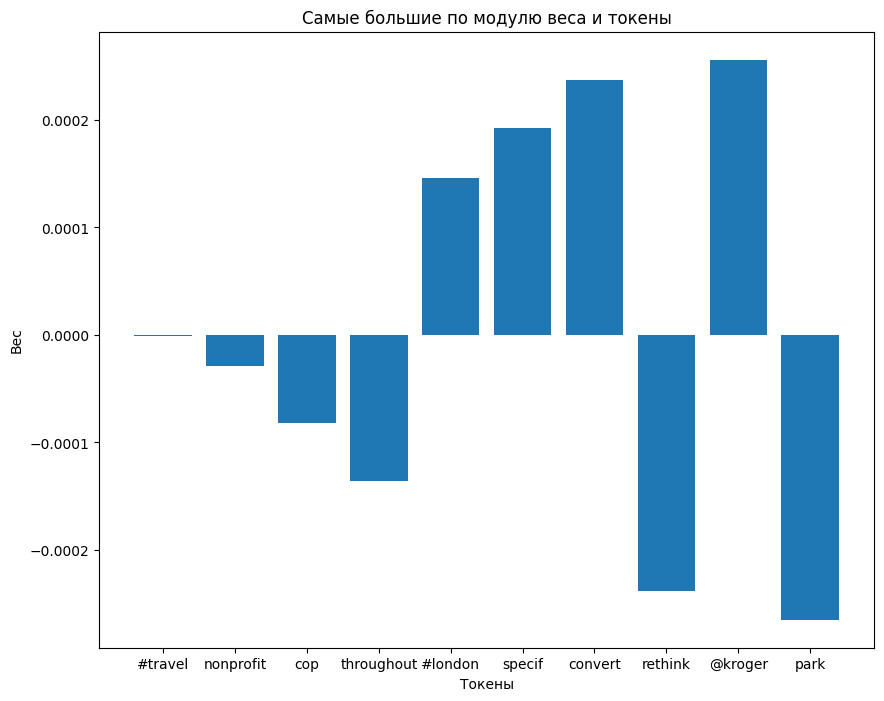

In [131]:
plt.figure(figsize = (10, 8))
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()))
plt.title('Самые большие по модулю веса и токены')
plt.xlabel('Токены')
plt.ylabel('Вес');

**Ответ:** Выбор токенов, которые больше всего влияют на определение моделью класса, довольно странный.
Можно предположить, что, например, предлог времени throughout используют чаще всего в негативной окраске, так как обычно используется "throughout the whole period". Или, например, то, что люди в Лондоне более положительно относились к ситуации (#london)

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучим признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

Эти признаки бессмысленно кодировать, так как если, например, использовать OneHotEncoder, то в test обязательно встретятся те пользователи, которые не были в train (то есть это не категориальная переменная, так как значения могут приниматься вплоть до бесконечности). При этом масштабирование тоже не придаст смысла, поэтому используем в истинном виде и проверим, повысилось ли качество

In [35]:
train_cv_df.toarray().shape

(23410, 3700)

In [46]:
#попробуем добавить в истинном виде
train_new = np.concatenate((train[['UserName', 'ScreenName']].to_numpy(), train_cv_df.toarray()), axis = 1)
test_new = np.concatenate((test[['UserName', 'ScreenName']].to_numpy(), test_cv_df.toarray()), axis = 1)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(train_new, y_train)
pred = clf.predict(test_new)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      4552
           1       0.86      0.87      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



In [121]:
pred_train = clf.predict(train_new)
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred))

Train 0.9237078171721487
Test 0.8517042057006179


**Ответ:** Если сранивать с результатами модели до масштабирования, то эта модель работает хуже (так как данные признаки не дают дополнительной помощи при определении окраски твита)
Однако если сравнивать с качеством модели, обученной после масштабирования, то эта модель улучшила качество

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [37]:
#преобразование к типу datetime
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst = True)
test['TweetAt'] = pd.to_datetime(test['TweetAt'], dayfirst = True)

In [42]:
train['TweetAt']

25621   2020-04-06
30135   2020-04-10
28899   2020-04-09
5989    2020-03-19
4367    2020-03-18
           ...    
20757   2020-03-31
32103   2020-04-13
30403   2020-04-10
21243   2020-04-01
2732    2020-03-18
Name: TweetAt, Length: 23410, dtype: datetime64[ns]

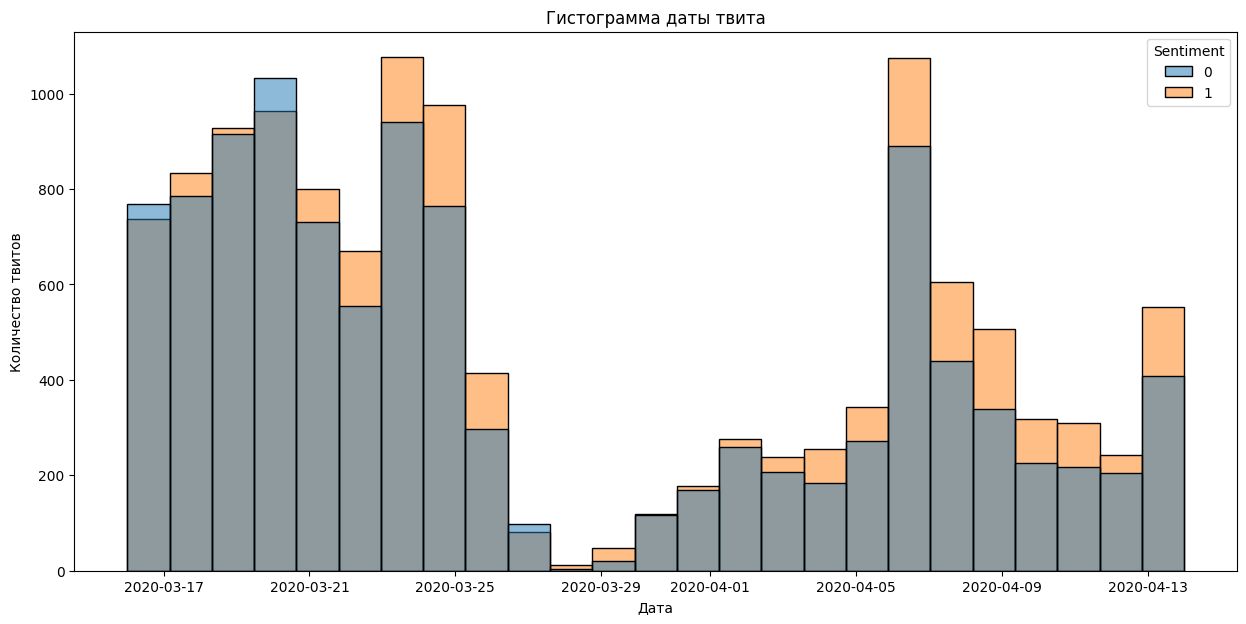

In [43]:
plt.figure(figsize = (15, 7))
sns.histplot(x = train['TweetAt'], hue = y_train)
#plt.xticks(rotation=90)
plt.title('Гистограмма даты твита')
plt.xlabel('Дата')
plt.ylabel('Количество твитов');

Так как дата - это не категориальная переменная, кодировать ее тоже нет смысла. Попробуем добавить переменные дня и месяца

In [48]:
#попробуем добавить в истинном виде
train_new = np.concatenate((train['TweetAt'].dt.day.to_numpy().reshape(-1, 1), train['TweetAt'].dt.month.to_numpy().reshape(-1, 1), train_cv_df.toarray()), axis = 1)
test_new = np.concatenate((test['TweetAt'].dt.day.to_numpy().reshape(-1, 1), test['TweetAt'].dt.month.to_numpy().reshape(-1, 1), test_cv_df.toarray()), axis = 1)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(train_new, y_train)
pred = clf.predict(test_new)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



**Ответ:** Видно, что качество модели не улучшилось, то есть эти переменные действительно не имеют смысла и не помогаюют в классификации твитов



Поработаем с признаком Location в обучающей выборке

In [49]:
print(f'Во всем датасете уникальных значений {df.Location.unique().shape[0]}')
print(f'Во обучающей выборке уникальных значений {train.Location.unique().shape[0]}')

Во всем датасете уникальных значений 10465
Во обучающей выборке уникальных значений 7949


Построем гистограмму топ-10 по популярности местоположений (исключая Unknown)

In [51]:
top = train.Location.value_counts()[1:11] #Убрали Unknown, который встречается чаще всего
top

Location
London             301
United States      295
London, England    274
New York, NY       223
Washington, DC     222
United Kingdom     204
Los Angeles, CA    154
India              153
UK                 133
Australia          118
Name: count, dtype: int64

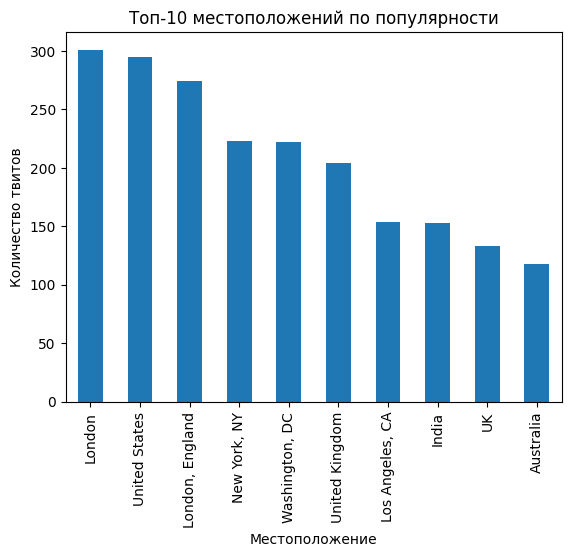

In [52]:
top.plot.bar()
plt.title('Топ-10 местоположений по популярности')
plt.xlabel('Местоположение')
plt.ylabel('Количество твитов');

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK)

In [53]:
train.Location.value_counts()

Location
Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: count, Length: 7949, dtype: int64

In [70]:
def func(location):
  num = location.count(',')
  location = location.strip()
  if location == 'Unknown':
    return 'Unknown'
  elif 'England' in location:
    return 'UK'
  elif num != 0:
    return location.split(', ')[-1]
  else:
    return location

In [71]:
train['WiderLocation'] = train.Location.apply(func)
test['WiderLocation'] = test.Location.apply(func)

In [72]:
print(f'Во обучающей выборке уникальных значений {train.WiderLocation.unique().shape[0]}')

Во обучающей выборке уникальных значений 4691


In [73]:
train.WiderLocation.value_counts()[1:11]

WiderLocation
UK                1430
USA                955
CA                 604
India              541
NY                 395
London             382
United States      306
Canada             293
United Kingdom     279
Australia          273
Name: count, dtype: int64

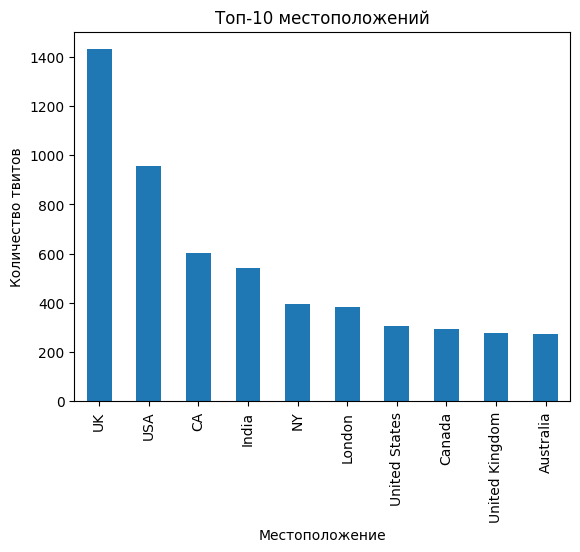

In [76]:
top = train.WiderLocation.value_counts()[1:11]
top.plot.bar()
plt.title('Топ-10 местоположений')
plt.xlabel('Местоположение')
plt.ylabel('Количество твитов');

Закодируем признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза


In [79]:
print('Количество значений, которые встречаются более одного раза')
train.WiderLocation.value_counts()[train.WiderLocation.value_counts() > 1].shape[0]

Количество значений, которые встречаются более одного раза


981

In [91]:
categories = list(train.WiderLocation.value_counts()[train.WiderLocation.value_counts() > 1].index.values[1:])

In [101]:
train.WiderLocation.apply(lambda x:np.NaN if x not in categories else x)

25621            NaN
30135            NaN
28899          India
5989              UK
4367             NaN
            ...     
20757            NaN
32103             TX
30403    Delhi India
21243            NaN
2732             NaN
Name: WiderLocation, Length: 23410, dtype: object

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", drop="first", min_frequency = 2)
ohe.fit(train.WiderLocation.to_numpy().reshape(-1, 1))
train_wl_transformed = ohe.transform(train.WiderLocation.to_numpy().reshape(-1, 1))
test_wl_transformed = ohe.transform(test.WiderLocation.to_numpy().reshape(-1, 1))

In [96]:
train_wl_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?

In [97]:
train_new = np.concatenate((train_wl_transformed.toarray(), train_cv_df.toarray()), axis = 1)
test_new = np.concatenate((test_wl_transformed.toarray(), test_cv_df.toarray()), axis = 1)
clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(train_new, y_train)
pred = clf.predict(test_new)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



In [98]:
pred_train = clf.predict(train_new)
print('Train',accuracy_score(y_train, pred_train))
print('Test',accuracy_score(y_test, pred))

Train 0.9457923964117898
Test 0.8444289415985649


**Ответ:** Качество модели ухудшилось и на тестовой, и на обучающей выборке